# Assignment 1

In [1]:
import pandas as pd
import numpy as np
import os
import puidata as pui

from scipy.stats import chi2_contingency

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 6

In [2]:
# Settings / Constants
datestring = '201501'
url = 'https://s3.amazonaws.com/tripdata/{}-citibike-tripdata.zip'

# Downloading data to PUIDATA
df = pui.csvLoader.load(url=url.format(datestring), is_zip=True).df

print('{} samples'.format(len(df)))
df.head()

Loaded from cache: /Users/bensteers/Desktop/Storage/NYU/Fall2017/PUI/data/201501-citibike-tripdata.csv
285552 samples


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


# IDEA:
### Subscribers are more likely to ride their bike during the week than customers.

# NULL HYPOTHESIS:
### The ratio of subscribers biking on weekends to weekdays is _the same_ or _higher_  than the ratio of customers  biking on weekends to weekdays.

# _$H_0$_ : $\frac{P_{cus,wkd}}{P_{cus,wk}} <= \frac{P_{sub,wkd}}{P_{sub,wk}}$
# _$H_A$_ : $\frac{P_{cus,wkd}}{P_{cus,wk}} >  \frac{P_{sub,wkd}}{P_{sub,wk}}$

### I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

In [3]:
# Drop any missing values
data = df.dropna(subset=['usertype', 'starttime']).copy()

# Use starttime as the date
data['date'] = pd.to_datetime(data['starttime'])

# Strip out unrelevant columns
data = data[['date', 'usertype']]

data.head()

,date,usertype
0,2015-01-01 00:01:00,Subscriber
1,2015-01-01 00:02:00,Subscriber
2,2015-01-01 00:04:00,Subscriber
3,2015-01-01 00:04:00,Subscriber
4,2015-01-01 00:05:00,Subscriber


<IPython.core.display.Javascript object>

In [4]:
# Get weekday counts
count_c = data.date[data['usertype'] == 'Customer'].groupby([data.date.dt.weekday]).count()
count_s = data.date[data['usertype'] == 'Subscriber'].groupby([data.date.dt.weekday]).count()

# Replace numerical weekdays with weekday names
daysofweek = dict(enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
count_c.index = count_c.index.to_series().map(daysofweek)
count_s.index = count_s.index.to_series().map(daysofweek)

# Display data
pd.DataFrame({
    'Customers': count_c,
    'Subscribers': count_s
})

,Customers,Subscribers
date,,
Mon,633,37369
Tue,369,38510
Wed,342,43025
Thu,1177,51728
Fri,1290,56539
Sat,800,27280
Sun,1017,25473


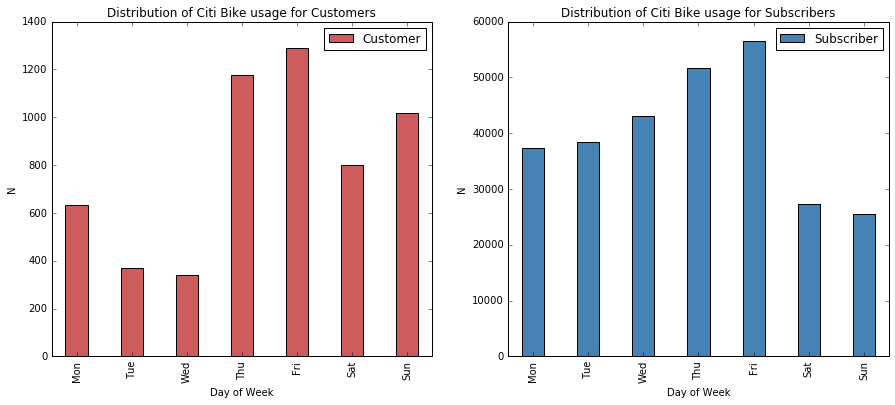

In [5]:
_width = 0.4

# Plot overall counts
plt.subplot(1,2,1)
count_c.plot(kind="bar", color='IndianRed', label='Customer', width=_width)
plt.title('Distribution of Citi Bike usage for Customers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend()

plt.subplot(1,2,2)
count_s.plot(kind="bar", color='SteelBlue', label='Subscriber', width=_width)
plt.title('Distribution of Citi Bike usage for Subscribers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend();

### Figure 1a. Distribution of Citibike users by user type in 01/2015, absolute counts
This plot shows the relative number of Citibike users over the course of the week for both customers and subscribers. Subscribers show a large relative dip over the weekend, while customers show a dip at the beginning/middle of the week. Both customers and subscribers have a peak on Thursday and Friday, implying that Citibike usage on those days are most likely influenced by a factor other than subscription status.

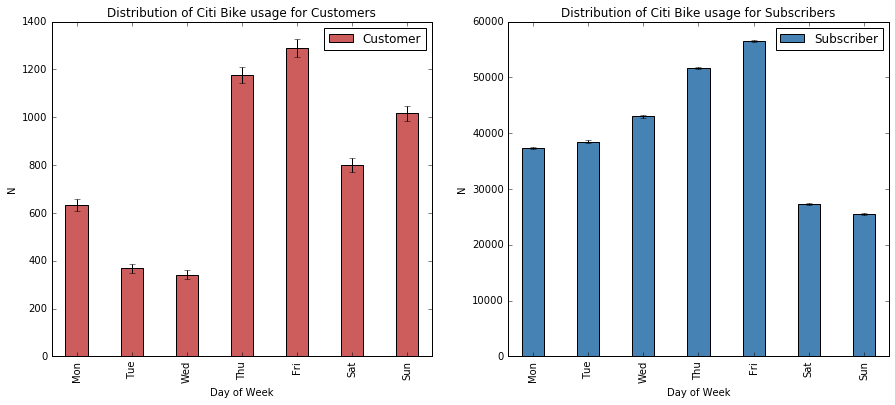

In [6]:
plt.subplot(1,2,1)
count_c.plot(kind="bar",color='IndianRed', width=_width, label='Customer',
                         yerr=[ [np.sqrt(count_c)]*2 ])
plt.title('Distribution of Citi Bike usage for Customers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend()

plt.subplot(1,2,2)
count_s.plot(kind="bar",color='SteelBlue', width=_width, label='Subscriber',
                         yerr=[[np.sqrt(count_s)]*2])
plt.title('Distribution of Citi Bike usage for Subscribers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend();

### Figure 1b. Distribution of Citi Biky users by day of the week and user type in 01/2015, absolute counts, with statistical errors
This plot shows the same information as Figure 1a, with statistical error bars added. The error bars look disproportionate because the overall magnitude of counts differs between the two user types.

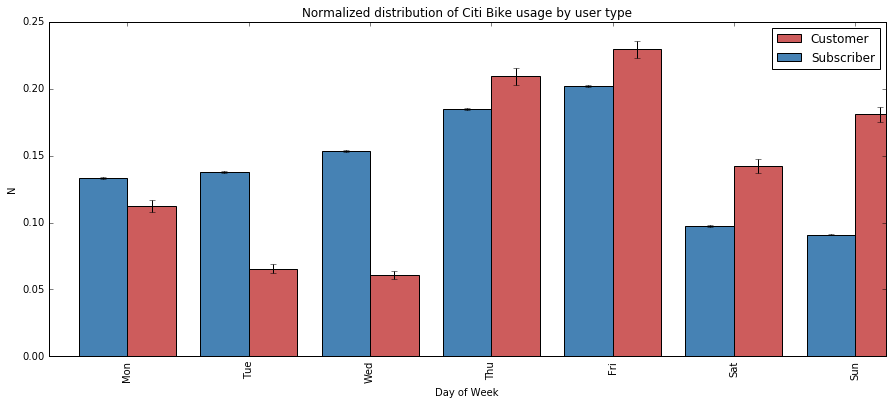

In [7]:
norm_c, norm_s = count_c.sum(), count_s.sum()

(count_c / norm_c).plot(kind="bar",color='IndianRed', position=0, width=_width,
                         yerr=[ [np.sqrt(count_c) / norm_c]*2 ], label='Customer')
(count_s / norm_s).plot(kind="bar",color='SteelBlue', position=1, width=_width,
                         yerr=[ [np.sqrt(count_s) / norm_s]*2 ], label='Subscriber')
plt.title('Normalized distribution of Citi Bike usage by user type')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend();

### Figure 2. Distribution of Citi Biky users by day of the week and user type in 01/2015, normalized
This plot shows the same information as Figures 1a and 1b, except the counts are normalized by their overall count. This shows how the distribution of Citibike users compare side by side over the course of a week. This shows that proportionally, subscribers bike more at the beginning of the week and customers tend to use Citibike towards the end of the week.

Subscribers: week:0.812, weekend:0.188, weekend error:0.002, weekend error:0.001
Customers: week:0.677, weekend:0.323, weekend error:0.011, weekend error:0.008


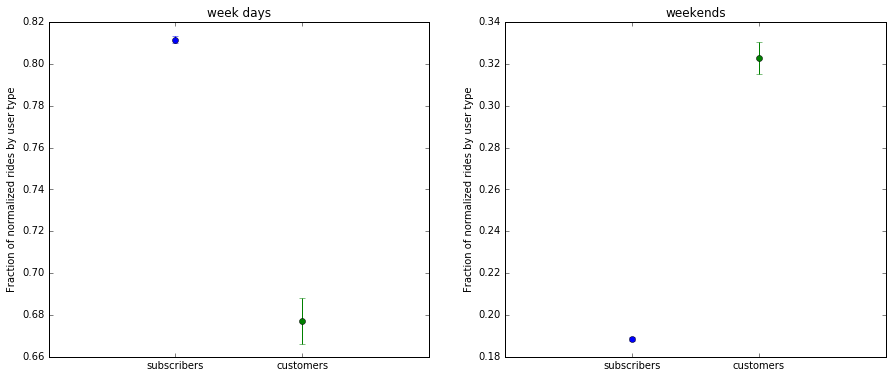

In [8]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

week_c = sum(count_c[:-2]) * 1.0 / norm_c  #fraction of customers riding on week days
weekend_c = sum(count_c[-2:]) * 1.0 / norm_c  #fraction of customers riding on weekends
eweek_c = np.sqrt(sum(count_c[:-2])) / norm_c  #error on week_c (sum squared errors where errors are poisson)
eweekend_c = np.sqrt(sum(count_c[-2:])) / norm_c #error on weekend_c

#same nomenclature as above for subscribers
week_s = sum(count_s[:-2]) * 1. / norm_s
weekend_s = sum(count_s[-2:]) * 1. / norm_s
eweek_s = np.sqrt(sum(count_s[:-2])) / norm_s
eweekend_s = np.sqrt(sum(count_s[-2:])) / norm_s

print("Subscribers: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_s, weekend_s, eweek_s, eweekend_s))
print("Customers: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_c, weekend_c, eweek_c, eweekend_c))

ax1.errorbar([0], [week_s], yerr=[eweek_s], fmt='o', label='subscribers')
ax1.errorbar([1], [week_c], yerr=[eweek_c], fmt='o', label='customers')
ax2.errorbar([0], [weekend_s], yerr=[eweekend_s], fmt='o', label='subscribers')
ax2.errorbar([1], [weekend_c], yerr=[eweekend_c], fmt='o', label='customers')
ax1.set_xlim(-1, 2)
ax2.set_xlim(-1, 2)
ax1.set_xticks([0, 1])
ax2.set_xticks([0, 1])
ax1.set_xticklabels(['subscribers', 'customers'])
ax2.set_xticklabels(['subscribers', 'customers'])
ax1.set_title("week days")
ax2.set_title("weekends")
ax1.set_ylabel("Fraction of normalized rides by user type")
ax2.set_ylabel("Fraction of normalized rides by user type");

### Figure 3: The fraction of rides by user type for the week and the weekend, normalized
This plot shows the comparison of normalized counts for user type over the week and the weekend respectively. This plot makes it clear that the distribution of subscribers is weighted towards the week and the distribution of customers is weighted towards the weekend.

### Checking the null hypothesis

#### _$H_0$_ : $\frac{P_{cus,wkd}}{P_{cus,wk}} <= \frac{P_{sub,wkd}}{P_{sub,wk}}$

In [9]:
P0mP1 = weekend_c / week_c - weekend_s / week_s
print ("difference between customers and subscribers weekend to week ratio: {:.4f}".format(P0mP1))
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

difference between customers and subscribers weekend to week ratio: 0.2446
We must check the significance before we reject the Null Hypothesis


### Is this difference statistically different?

In [10]:
contingency_table_a = pd.DataFrame([
    [week_c, week_s],
    [weekend_c, weekend_s]
], columns=['Customers', 'Subscribers'], index=['Week', 'Weekend'])

print('chi-squared: {:.3f}, p-value: {}'.format(*chi2_contingency(contingency_table.values)[:2]))
contingency_table

chi-squared: 1.969, p-value: 0.160583981585


,Customers,Subscribers
Week,0.67715,0.811545
Weekend,0.32285,0.188455


#### The p-value returned by the chi-squared test was not below the significance threshold of 0.05, meaning that the null hypothesis cannot be rejected.

# Testing on another month

In [11]:
# Settings / Constants
datestrings = ['201505', '201506', '201507', '201508']

# Downloading data to PUIDATA
df = pd.concat([
    pui.csvLoader.load(url=url.format(datestring), is_zip=True).df
    for datestring in datestrings
]).reset_index(drop=True)

print('{} samples'.format(len(df)))
df.head()

Loaded from cache: /Users/bensteers/Desktop/Storage/NYU/Fall2017/PUI/data/201505-citibike-tripdata.csv
Loaded from cache: /Users/bensteers/Desktop/Storage/NYU/Fall2017/PUI/data/201506-citibike-tripdata.csv
Loaded from cache: /Users/bensteers/Desktop/Storage/NYU/Fall2017/PUI/data/201507-citibike-tripdata.csv
Loaded from cache: /Users/bensteers/Desktop/Storage/NYU/Fall2017/PUI/data/201508-citibike-tripdata.csv
4167925 samples


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,415,5/1/2015 00:00:11,5/1/2015 00:07:06,477,W 41 St & 8 Ave,40.756405,-73.990026,442,W 27 St & 7 Ave,40.746647,-73.993915,17012,Subscriber,1981.0,1
1,1523,5/1/2015 00:00:28,5/1/2015 00:25:52,293,Lafayette St & E 8 St,40.730287,-73.990765,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,17390,Customer,NaN,0
2,642,5/1/2015 00:00:52,5/1/2015 00:11:35,380,W 4 St & 7 Ave S,40.734011,-74.002939,507,E 25 St & 2 Ave,40.739126,-73.979738,15003,Subscriber,1990.0,1
3,367,5/1/2015 00:00:48,5/1/2015 00:06:55,537,Lexington Ave & E 24 St,40.740259,-73.984092,280,E 10 St & 5 Ave,40.733320,-73.995101,14788,Subscriber,1978.0,1
4,2734,5/1/2015 00:00:51,5/1/2015 00:46:26,426,West St & Chambers St,40.717548,-74.013221,327,Vesey Pl & River Terrace,40.715338,-74.016584,21068,Subscriber,1956.0,2


In [20]:
# Drop any missing values
data = df.dropna(subset=['usertype', 'starttime']).copy()

# Use starttime as the date
data['date'] = pd.to_datetime(data['starttime'])

# Strip out unrelevant columns
data = data[['date', 'usertype']]

# Get weekday counts
count_c = data.date[data['usertype'] == 'Customer'].groupby([data.date.dt.weekday]).count()
count_s = data.date[data['usertype'] == 'Subscriber'].groupby([data.date.dt.weekday]).count()

# Replace numerical weekdays with weekday names
daysofweek = dict(enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
count_c.index = count_c.index.to_series().map(daysofweek)
count_s.index = count_s.index.to_series().map(daysofweek)

# Display data
df_tmp = pd.DataFrame({
    'Customers': count_c,
    'Subscribers': count_s
})

# caching
pui.csvLoader(filename='puihw7a1_week_counts.csv').set_df(df_tmp).save_cache()
# df_tmp = pui.csvLoader.load(filename='puihw7a1_week_counts.csv').df
# count_c, count_s = df_tmp['Customers'], df_tmp['Subscribers']
df_tmp

,Customers,Subscribers
date,,
Mon,84517,531964
Tue,63406,523428
Wed,68404,573061
Thu,76403,561891
Fri,93908,560094
Sat,158885,359820
Sun,153760,358384


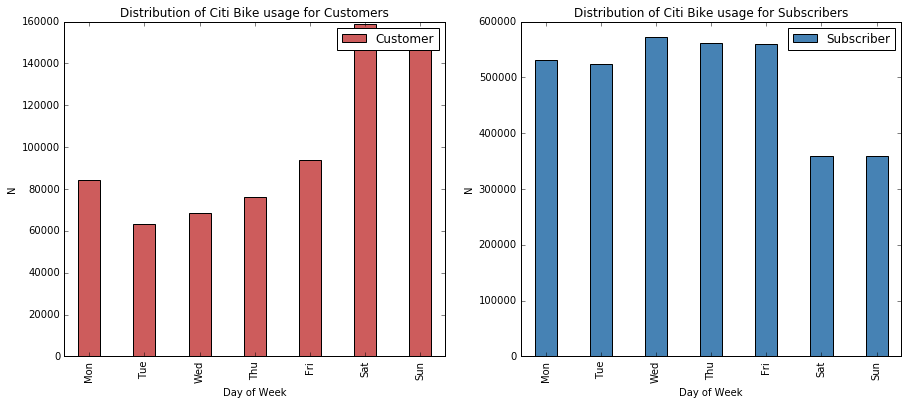

In [13]:
# Plot overall counts
plt.subplot(1,2,1)
count_c.plot(kind="bar", color='IndianRed', label='Customer', width=_width)
plt.title('Distribution of Citi Bike usage for Customers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend()

plt.subplot(1,2,2)
count_s.plot(kind="bar", color='SteelBlue', label='Subscriber', width=_width)
plt.title('Distribution of Citi Bike usage for Subscribers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend();

### Figure 4a: Distribution of Citibike users by user type in for May to August 2015, absolute counts
This plot shows the relative number of Citibike users over the course of the week for both customers and subscribers. Subscribers show a large relative dip over the weekend, while customers show a dip at the beginning/middle of the week. Both customers and subscribers have a peak on Thursday and Friday, implying that Citibike usage on those days are most likely influenced by a factor other than subscription status.

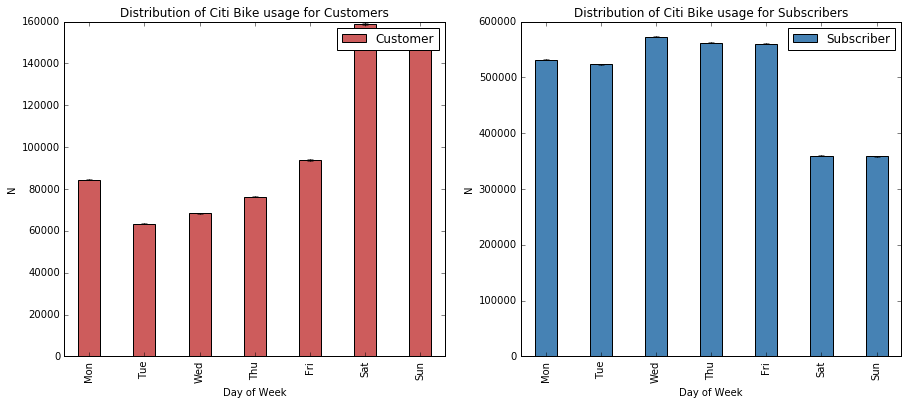

In [14]:
plt.subplot(1,2,1)
count_c.plot(kind="bar",color='IndianRed', width=_width, label='Customer',
                         yerr=[ [np.sqrt(count_c)]*2 ])
plt.title('Distribution of Citi Bike usage for Customers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend()

plt.subplot(1,2,2)
count_s.plot(kind="bar",color='SteelBlue', width=_width, label='Subscriber',
                         yerr=[[np.sqrt(count_s)]*2])
plt.title('Distribution of Citi Bike usage for Subscribers')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend();

### Figure 4b: The same as Figure 1b, using 4 months of data.

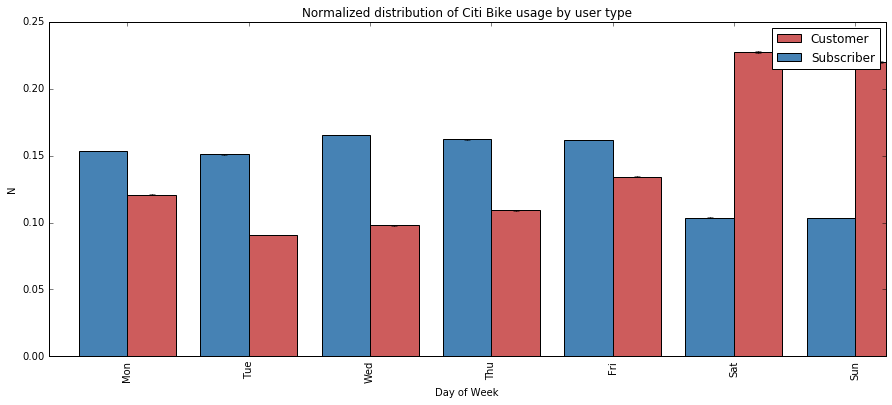

In [15]:
norm_c, norm_s = count_c.sum(), count_s.sum()

(count_c / norm_c).plot(kind="bar",color='IndianRed', position=0, width=_width,
                         yerr=[ [np.sqrt(count_c) / norm_c]*2 ], label='Customer')
(count_s / norm_s).plot(kind="bar",color='SteelBlue', position=1, width=_width,
                         yerr=[ [np.sqrt(count_s) / norm_s]*2 ], label='Subscriber')
plt.title('Normalized distribution of Citi Bike usage by user type')
plt.xlabel('Day of Week')
plt.ylabel('N')
plt.legend();

### Figure 4b: The same as Figure 2, using 4 months of data.

Subscribers: week:0.793, weekend:0.207, weekend error:0.000, weekend error:0.000
Customers: week:0.553, weekend:0.447, weekend error:0.001, weekend error:0.001


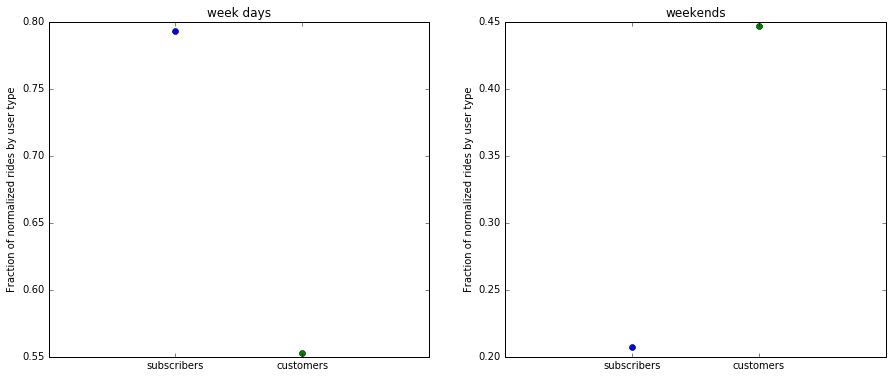

In [16]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

week_c = sum(count_c[:-2]) * 1.0 / norm_c  #fraction of customers riding on week days
weekend_c = sum(count_c[-2:]) * 1.0 / norm_c  #fraction of customers riding on weekends
eweek_c = np.sqrt(sum(count_c[:-2])) / norm_c  #error on week_c (sum squared errors where errors are poisson)
eweekend_c = np.sqrt(sum(count_c[-2:])) / norm_c #error on weekend_c

#same nomenclature as above for subscribers
week_s = sum(count_s[:-2]) * 1. / norm_s
weekend_s = sum(count_s[-2:]) * 1. / norm_s
eweek_s = np.sqrt(sum(count_s[:-2])) / norm_s
eweekend_s = np.sqrt(sum(count_s[-2:])) / norm_s

print("Subscribers: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_s, weekend_s, eweek_s, eweekend_s))
print("Customers: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_c, weekend_c, eweek_c, eweekend_c))

ax1.errorbar([0], [week_s], yerr=[eweek_s], fmt='o', label='subscribers')
ax1.errorbar([1], [week_c], yerr=[eweek_c], fmt='o', label='customers')
ax2.errorbar([0], [weekend_s], yerr=[eweekend_s], fmt='o', label='subscribers')
ax2.errorbar([1], [weekend_c], yerr=[eweekend_c], fmt='o', label='customers')
ax1.set_xlim(-1, 2)
ax2.set_xlim(-1, 2)
ax1.set_xticks([0, 1])
ax2.set_xticks([0, 1])
ax1.set_xticklabels(['subscribers', 'customers'])
ax2.set_xticklabels(['subscribers', 'customers'])
ax1.set_title("week days")
ax2.set_title("weekends")
ax1.set_ylabel("Fraction of normalized rides by user type")
ax2.set_ylabel("Fraction of normalized rides by user type");

### Checking the null hypothesis

#### _$H_0$_ : $\frac{P_{cus,wkd}}{P_{cus,wk}} <= \frac{P_{sub,wkd}}{P_{sub,wk}}$

In [17]:
P0mP1 = weekend_c / week_c - weekend_s / week_s
print ("difference between customers and subscribers weekend to week ratio: {:.4f}".format(P0mP1))
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

difference between customers and subscribers weekend to week ratio: 0.5475
We must check the significance before we reject the Null Hypothesis


### Is this difference statistically different?

In [18]:
contingency_table = pd.DataFrame([
    [week_c, week_s],
    [weekend_c, weekend_s]
], columns=['Customers', 'Subscribers'], index=['Week', 'Weekend'])

print('chi-squared: {:.3f}, p-value: {}'.format(*chi2_contingency(contingency_table.values)[:2]))
contingency_table

chi-squared: 1.312, p-value: 0.252029257111


,Customers,Subscribers
Week,0.552906,0.792944
Weekend,0.447094,0.207056


#### The p-value is larger than the significance threshold meaning that the null hypothesis cannot be rejected.